# Inicializar

In [1]:
from Modelos.base_model import base_model
from Modelos.serie_model import serie_model
from Modelos.parallel_model import parallel_model
from Modelos.hibrid_model import hibrid_model
from utils.utils import mostrarResultadosTabla, generate_equidistant_list, graficar_costos_minimizados

In [2]:
totalNodes = 10
linkCost = 10
costByNodeType = {0: 5, 1: 12, 2: 20}
reliabilityByNodeType = {0: 0.6, 1: 0.7, 2: 0.8}
baseModel = base_model(totalNodes, costByNodeType)

Restricted license - for non-production use only - expires 2026-11-23


# Pruebas

## Serie

In [3]:
# Obtener la confiabilidad mínima y máxima obtenibles para el modelo serie
# Hacer una lista de confiabilidades equidistantes entre la mínima y máxima
seriesMinReliability = reliabilityByNodeType[0] ** totalNodes
seriesMaxReliability = reliabilityByNodeType[2] ** totalNodes
seriesRequiredReliabilities = generate_equidistant_list(seriesMinReliability, seriesMaxReliability, 10)
print(seriesMinReliability, seriesMaxReliability)
print(seriesRequiredReliabilities)

0.006046617599999997 0.10737418240000006
[0.0152582144, 0.0244698112, 0.033681408, 0.0428930048, 0.0521046016, 0.0613161984, 0.0705277952, 0.079739392, 0.0889509888, 0.0981625856]


In [4]:
# Crear y optimizar el modelo en serie
try:
    seriesMinCost, seriesVars, seriesModel = serie_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, seriesRequiredReliabilities[5])
    mostrarResultadosTabla(totalNodes, seriesMinCost, seriesVars)
except Exception as e:
    print(f"Error: {e}")

Cantidad de Nodos: 10
Resultado de la Optimización:
Costo Total: 258.0
Costo nodos: 168.0
Costo enlaces: 90.0
Nodos activos (x):
    Low Cost  Mid Cost  High Cost
1          0         1          0
2          0         1          0
3          0         0          1
4          0         0          1
5          0         0          1
6          0         1          0
7          0         0          1
8          0         0          1
9          0         0          1
10         0         1          0


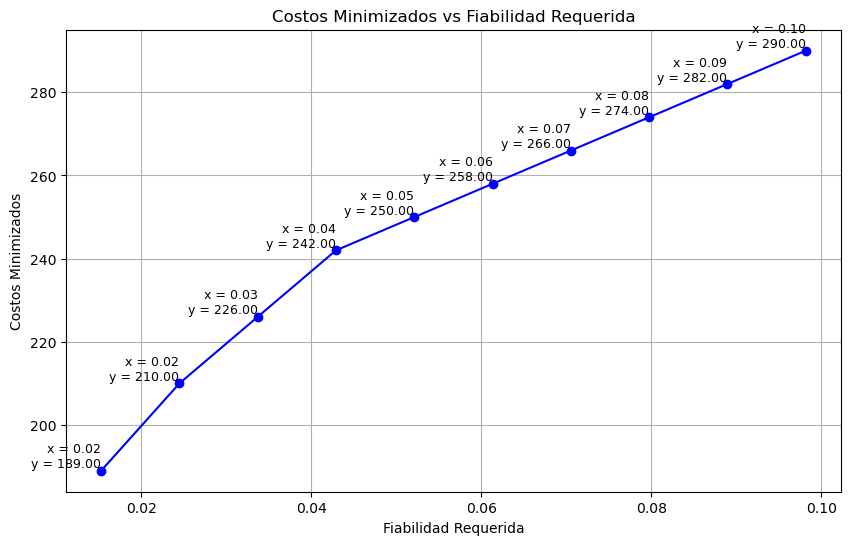

In [5]:
# Graficar los costos minimizados para cada confiabilidad requerida
try:
    serieMinimizedCosts = []
    for reqReliability in seriesRequiredReliabilities:
        minCost, seriesVars, seriesModel = serie_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, reqReliability)
        serieMinimizedCosts.append(minCost)
    graficar_costos_minimizados(seriesRequiredReliabilities, serieMinimizedCosts)
except ValueError as e:
    print(f"Error: {e}")

## Paralelo

In [6]:
# Obtener la confiabilidad mínima y máxima obtenibles para el modelo en paralelo
# Hacer una lista de confiabilidades equidistantes entre la mínima y máxima
parallelMinReliability = 1 - ((1 - reliabilityByNodeType[0]) ** totalNodes)
parallelMaxReliability = 1 - ((1 - reliabilityByNodeType[2]) ** totalNodes)
parallelRequiredReliabilities = generate_equidistant_list(parallelMinReliability, parallelMaxReliability, 10)
print(parallelMinReliability, parallelMaxReliability)
print(parallelRequiredReliabilities)

0.9998951424 0.9999998976
[0.9999046656, 0.9999141888, 0.999923712, 0.9999332352, 0.9999427584, 0.9999522816, 0.9999618048, 0.999971328, 0.9999808512, 0.9999903744]


In [7]:
# Crear y optimizar el modelo en paralelo
try:
    parallelMinCost, parallelVars, parallelModel = parallel_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, parallelRequiredReliabilities[3])
    mostrarResultadosTabla(totalNodes, parallelMinCost, parallelVars)
except Exception as e:
    print(f"Error: {e}")

Cantidad de Nodos: 10
Resultado de la Optimización:
Costo Total: 514.0
Costo nodos: 64.0
Costo enlaces: 450.0
Nodos activos (x):
    Low Cost  Mid Cost  High Cost
1          1         0          0
2          0         1          0
3          1         0          0
4          1         0          0
5          1         0          0
6          1         0          0
7          1         0          0
8          1         0          0
9          1         0          0
10         0         1          0


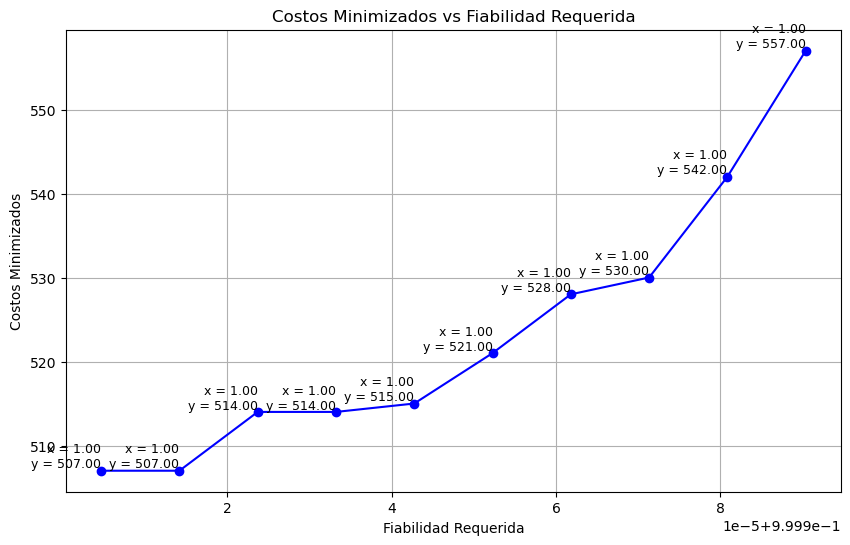

In [8]:
# Graficar los costos minimizados para cada confiabilidad requerida
try:
    parallelMinimizedCosts = []
    for reqReliability in parallelRequiredReliabilities:
        minCost, parallelVars, parallelModel = parallel_model(baseModel, totalNodes, linkCost, reliabilityByNodeType, reqReliability)
        parallelMinimizedCosts.append(minCost)
    graficar_costos_minimizados(parallelRequiredReliabilities, parallelMinimizedCosts)
except ValueError as e:
    print(f"Error: {e}")

## Hibrido

In [9]:
# Crear y optimizar el modelo híbrido
try:
    hybridMinCost, hybridVars, hybridModel = hibrid_model(baseModel, totalNodes, linkCost)
    mostrarResultadosTabla(totalNodes, hybridMinCost, hybridVars, "hibrido")
except Exception as e:
    print(f"Error: {e}")

Cantidad de Nodos: 10
Resultado de la Optimización:
Costo Total: 150.0
Costo nodos: 50.0
Costo enlaces: 100.0
Nodos activos (x):
    Low Cost  Mid Cost  High Cost
1          1         0          0
2          1         0          0
3          1         0          0
4          1         0          0
5          1         0          0
6          1         0          0
7          1         0          0
8          1         0          0
9          1         0          0
10         1         0          0
Nodos activos (y):
    Subred 0  Subred 1  Subred 2  Subred 3
1          1         0         0         0
2          1         0         0         0
3          0         1         0         0
4          0         1         0         0
5          0         1         0         0
6          1         0         0         0
7          1         0         0         0
8          1         0         0         0
9          1         0         0         0
10         1         0         0         0
